# 05a - Vertex AI > Training > Custom Jobs - With Python file

### 05 Series Overview
Where a model gets trained is where it consumes computing resources.  With Vertex AI, you have choices for configuring the computing resources available at training.  This notebook is an example of an execution environment.  When it was set up there were choices for machine type and accelerators (GPUs).  

In the `05` notebook, the model training happened directly in the notebook.  The models were then imported to Vertex AI and deployed to an endpoint for online predictions. 

In this `05a-05i` series of demonstrations, the same model is trained using managed computing resources in Vertex AI as custom training jobs.  These jobs will be demonstrated as:

-  Custom Job from a python script (`05a`), python source distribution (`05b`), and custom container (`05c`)
-  Training Pipeline that trains and saves models from a python script (`05d`), python source distribution (`05e`), and custom container (`05f`)
-  Hyperparameter Tuning Jobs from a python script (`05g`), python source distribution (`05h`), and custom container (`05i`)

### This Notebook (`05a`): An extension of `05` that saves the notebook code for the model as a Python script
This notebook trains the same Tensorflow Keras model from `05` by first modifying and saving the training code to a python script.  The script is then used as an input for a Vertex AI > Training > Custom Job that is also assigned compute resources and a [pre-built container for custom training](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers) for executing the training in a managed service. This is done with the [Vertex AI Python SDK](https://googleapis.dev/python/aiplatform/latest/aiplatform.html#) using the class [`aiplatform.CustomJob.from_local_script()`](https://googleapis.dev/python/aiplatform/latest/aiplatform.html#google.cloud.aiplatform.CustomJob.from_local_script).

The training can be reviewed with Vertex AI's managed Tensorboard under Vertex AI > Experiments > Experiments, or by clicking on the `05a...` custom job under Vertex AI > Training > Custom Jobs and then clicking the 'Open Tensorboard' link.

<img src="architectures/overview/Training.png">

### Prerequisites:
-  01 - BigQuery - Table Data Source
-  Understanding:
    -  05 - Vertex AI > Notebooks - Models Built in Notebooks with Tensorflow
        -  Contains a more granular review of the Tensorflow model training

### Overview:
-  Setup
-  Connect to Tensorboard instance from 05
-  Create a `train.py` Python script that recreates the local training in 05
-  Use Python Client google.cloud.aiplatform for Vertex AI
   -  Custom training job with aiplatform.CustomJob.from_local_script
      -  Run job with .run
   -  Upload Model to Vertex AI with aiplatform.Model.upload
   -  Create Endpoint with Vertex AI with aiplatform.Endpoint.create
      -  Deploy model to endpoint with .deploy 
-  Online Prediction demonstrated using Vertex AI Endpoint with deployed model
   -  Get records to score from BigQuery table
   -  Prediction with aiplatform.Endpoint.predict
   -  Prediction with REST
   -  Prediction with gcloud (CLI)

### Resources:
-  [BigQuery Tensorflow Reader](https://www.tensorflow.org/io/tutorials/bigquery)
-  [Keras Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)
   -  [Keras API](https://www.tensorflow.org/api_docs/python/tf/keras)
-  [Python Client For Google BigQuery](https://googleapis.dev/python/bigquery/latest/index.html)
-  [Tensorflow Python Client](https://www.tensorflow.org/api_docs/python/tf)
-  [Tensorflow I/O Python Client](https://www.tensorflow.org/io/api_docs/python/tfio/bigquery)
-  [Python Client for Vertex AI](https://googleapis.dev/python/aiplatform/latest/aiplatform.html)
-  Containers for training (Pre-Built)
   -  [Overview](https://cloud.google.com/vertex-ai/docs/training/create-python-pre-built-container)
    - Pre-built Containers for Vertex AI
        - [Training](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers)
        - [Prediction & Explaination](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers)





---
## Vertex AI - Conceptual Flow

<img src="architectures/slides/05a_arch.png">

---
## Vertex AI - Workflow

<img src="architectures/slides/05a_console.png">

---
## Setup

inputs:

In [1]:
REGION = 'us-central1'
PROJECT_ID='ma-mx-presales-lab'
DATANAME = 'fraud'
NOTEBOOK = '05a'

# Resources
TRAIN_IMAGE = 'us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-7:latest'
DEPLOY_IMAGE ='us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-7:latest'
TRAIN_COMPUTE = 'n1-standard-4'
DEPLOY_COMPUTE = 'n1-standard-4'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters
EPOCHS = 10
BATCH_SIZE = 100

packages:

In [2]:
from google.cloud import aiplatform
from datetime import datetime

from google.cloud import bigquery
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np

clients:

In [3]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bigquery = bigquery.Client()

parameters:

In [6]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = "vertex-ai-mlops-bucket"
URI = f"gs://{BUCKET}/{DATANAME}/models/{NOTEBOOK}"
DIR = f"temp/{NOTEBOOK}"

In [7]:
# Give service account roles/storage.objectAdmin permissions
# Console > IMA > Select Account <projectnumber>-compute@developer.gserviceaccount.com > edit - give role
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'825075454589-compute@developer.gserviceaccount.com'

environment:

In [8]:
!rm -rf {DIR}
!mkdir -p {DIR}

---
## Get Vertex AI Experiments Tensorboard Instance Name
[Vertex AI Experiments](https://cloud.google.com/vertex-ai/docs/experiments/tensorboard-overview) has managed [Tensorboard](https://www.tensorflow.org/tensorboard) instances that you can track Tensorboard Experiments (a training run or hyperparameter tuning sweep).  

The training job will show up as an experiment for the Tensorboard instance and have the same name as the training job ID.

This code checks to see if a Tensorboard Instance has been created in the project, retrieves it if so, creates it otherwise:

In [10]:
# tb = aiplatform.Tensorboard.list(filter=f'display_name={DATANAME}')
# if tb:
#     tb = tb[0]
# else:
#     tb = aiplatform.Tensorboard.create(display_name = DATANAME, labels = {'notebook':f'{DATANAME}'})

In [9]:
#tb.resource_name

---
## Training

### Assemble Python File for Training

Create the main python trainer file as `/train.py`:

In [11]:
%%writefile {DIR}/train.py

# package import
from tensorflow.python.framework import dtypes
from tensorflow_io.bigquery import BigQueryClient
import tensorflow as tf
from google.cloud import bigquery
import argparse
import os
import sys

# import argument to local variables
parser = argparse.ArgumentParser()
# the passed param, dest: a name for the param, default: if absent fetch this param from the OS, type: type to convert to, help: description of argument
parser.add_argument('--epochs', dest = 'epochs', default = 10, type = int, help = 'Number of Epochs')
parser.add_argument('--batch_size', dest = 'batch_size', default = 32, type = int, help = 'Batch Size')
parser.add_argument('--var_target', dest = 'var_target', type=str)
parser.add_argument('--var_omit', dest = 'var_omit', type=str, nargs='*')
parser.add_argument('--project_id', dest = 'project_id', type=str)
parser.add_argument('--dataname', dest = 'dataname', type=str)
parser.add_argument('--region', dest = 'region', type=str)
parser.add_argument('--notebook', dest = 'notebook', type=str)
args = parser.parse_args()

# built in parameters for data source:
PROJECT_ID = args.project_id
DATANAME = args.dataname
REGION = args.region
NOTEBOOK = args.notebook

# clients
bigquery = bigquery.Client(project = PROJECT_ID)

# get schema from bigquery source
query = f"SELECT * FROM {DATANAME}.INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = '{DATANAME}_prepped'"
schema = bigquery.query(query).to_dataframe()

# get number of classes from bigquery source
nclasses = bigquery.query(query = f'SELECT DISTINCT {args.var_target} FROM {DATANAME}.{DATANAME}_prepped WHERE {args.var_target} is not null').to_dataframe()
nclasses = nclasses.shape[0]

# Make a list of columns to omit
OMIT = args.var_omit + ['splits']

# use schema to prepare a list of columns to read from BigQuery
selected_fields = schema[~schema.column_name.isin(OMIT)].column_name.tolist()

# all the columns in this data source are either float64 or int64
output_types = [dtypes.float64 if x=='FLOAT64' else dtypes.int64 for x in schema[~schema.column_name.isin(OMIT)].data_type.tolist()]

# remap input data to Tensorflow inputs of features and target
def transTable(row_dict):
    target=row_dict.pop(args.var_target)
    target = tf.one_hot(tf.cast(target,tf.int64), nclasses)
    target = tf.cast(target, tf.float32)
    return(row_dict,target)

# function to setup a bigquery reader with Tensorflow I/O
def bq_reader(split):
    reader = BigQueryClient()

    training = reader.read_session(
        parent = f"projects/{PROJECT_ID}",
        project_id = PROJECT_ID,
        table_id = f"{DATANAME}_prepped",
        dataset_id = DATANAME,
        selected_fields = selected_fields,
        output_types = output_types,
        row_restriction = f"splits='{split}'",
        requested_streams = 3
    )
    
    return training

train = bq_reader('TRAIN').parallel_read_rows().prefetch(1).map(transTable).shuffle(args.batch_size*10).batch(args.batch_size)
validate = bq_reader('VALIDATE').parallel_read_rows().prefetch(1).map(transTable).batch(args.batch_size)
test = bq_reader('TEST').parallel_read_rows().prefetch(1).map(transTable).batch(args.batch_size)

# Logistic Regression

# model input definitions
feature_columns = {header: tf.feature_column.numeric_column(header) for header in selected_fields if header != args.var_target}
feature_layer_inputs = {header: tf.keras.layers.Input(shape = (1,), name = header) for header in selected_fields if header != args.var_target}

# feature columns to a Dense Feature Layer
feature_layer_outputs = tf.keras.layers.DenseFeatures(feature_columns.values())(feature_layer_inputs)

# batch normalization then Dense with softmax activation to nclasses
layers = tf.keras.layers.BatchNormalization()(feature_layer_outputs)
layers = tf.keras.layers.Dense(nclasses, activation = tf.nn.softmax)(layers)

# the model
model = tf.keras.Model(
    inputs = feature_layer_inputs,
    outputs = layers
)
opt = tf.keras.optimizers.SGD() #SGD or Adam
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(
    optimizer = opt,
    loss = loss,
    metrics = ['accuracy', tf.keras.metrics.AUC(curve='PR')]
)

# setup tensorboard logs and train
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.environ['AIP_TENSORBOARD_LOG_DIR'], histogram_freq=1)
history = model.fit(train, epochs = args.epochs, callbacks = [tensorboard_callback], validation_data = validate)

# output the model save files
model.save(os.getenv("AIP_MODEL_DIR"))

Writing temp/05a/train.py


### Setup Training Job

In [12]:
CMDARGS = [
    "--epochs=" + str(EPOCHS),
    "--batch_size=" + str(BATCH_SIZE),
    "--var_target=" + VAR_TARGET,
    "--var_omit=" + VAR_OMIT,
    "--project_id=" + PROJECT_ID,
    "--dataname=" + DATANAME,
    "--region=" + REGION,
    "--notebook=" + NOTEBOOK
]

In [13]:
customJob = aiplatform.CustomJob.from_local_script(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    script_path = f"{DIR}/train.py",
    container_uri = TRAIN_IMAGE,
    args = CMDARGS,
    requirements = ['tensorflow_io'],
    replica_count = 1,
    machine_type = TRAIN_COMPUTE,
    accelerator_count = 0,
    base_output_dir = f"{URI}/{TIMESTAMP}",
    staging_bucket = f"{URI}/{TIMESTAMP}",
    labels = {'notebook':f'{NOTEBOOK}'}
)

INFO:google.cloud.aiplatform.utils.source_utils:Training script copied to:
gs://vertex-ai-mlops-bucket/fraud/models/05a/20220401020254/aiplatform-2022-04-01-02:05:09.019-aiplatform_custom_trainer_script-0.1.tar.gz.


#### Environment variables


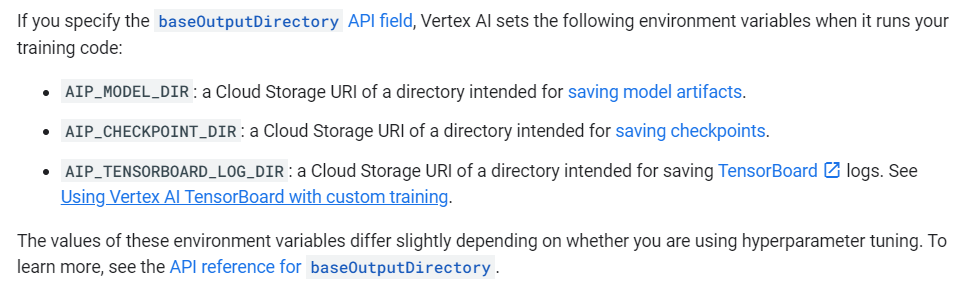

See: https://cloud.google.com/vertex-ai/docs/training/code-requirements#environment-variables

### Run Training Job

In [14]:
customJob.run(
    service_account = SERVICE_ACCOUNT#,
    #tensorboard = tb.resource_name
)

INFO:google.cloud.aiplatform.jobs:Creating CustomJob
INFO:google.cloud.aiplatform.jobs:CustomJob created. Resource name: projects/825075454589/locations/us-central1/customJobs/614834257868619776
INFO:google.cloud.aiplatform.jobs:To use this CustomJob in another session:
INFO:google.cloud.aiplatform.jobs:custom_job = aiplatform.CustomJob.get('projects/825075454589/locations/us-central1/customJobs/614834257868619776')
INFO:google.cloud.aiplatform.jobs:View Custom Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/614834257868619776?project=825075454589
INFO:google.cloud.aiplatform.jobs:CustomJob projects/825075454589/locations/us-central1/customJobs/614834257868619776 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:CustomJob projects/825075454589/locations/us-central1/customJobs/614834257868619776 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:CustomJob projects/825075454589/locations/us-central1/custo

In [15]:
customJob.display_name

'05a_fraud_20220401020254'

### Local (free) TensorBoard

In [16]:
%load_ext tensorboard

In [18]:
!mkdir $DIR/logs

In [20]:
!gsutil cp -r gs://vertex-ai-mlops-bucket/fraud/models/05a/20220401020254/logs/* $DIR/logs

Copying gs://vertex-ai-mlops-bucket/fraud/models/05a/20220401020254/logs/train/events.out.tfevents.1648778895.d6bab930660b.378.0.v2...
/ [1 files][176.6 KiB/176.6 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://vertex-ai-mlops-bucket/fraud/models/05a/20220401020254/logs/validation/events.out.tfevents.1648778927.d6bab930660b.378.1.v2...
/ [2 files][181.2 KiB/181.2 KiB]                                                
Operation completed over 2 objects/181.2 KiB.                                    


In [23]:
%tensorboard --logdir $DIR/logs

Reusing TensorBoard on port 6007 (pid 14671), started 0:01:45 ago. (Use '!kill 14671' to kill it.)

In [24]:
!tensorboard dev upload --logdir $DIR/logs \
  --name "Simple experiment from GCP" \
  --description "Training results from Notebook 05a" \
  --one_shot

2022-04-01 02:20:34.652866: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-04-01 02:20:34.652936: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-01 02:20:34.652973: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tensorflow-2-7-20220125-120050): /proc/driver/nvidia/version does not exist

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/oq8E1zqWRCKwbDCXqr779A/

[2022-04-01T02:20:34] Started scanning logdir.
[2022-04-01T02:20:35] Total uploaded: 90 scalars, 60 tensors (43.1 kB), 1 binary objects (114.6 kB)
[2022-04-01T02:20:35] Done scanning logdir.


Done. View your TensorBoard at htt

---
## Serving

### Upload The Model

In [25]:
model = aiplatform.Model.upload(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    serving_container_image_uri = DEPLOY_IMAGE,
    artifact_uri = f"{URI}/{TIMESTAMP}/model",
    labels = {'notebook':f'{NOTEBOOK}'}
)

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/825075454589/locations/us-central1/models/5716919504714334208/operations/4510410620868231168
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/825075454589/locations/us-central1/models/5716919504714334208
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/825075454589/locations/us-central1/models/5716919504714334208')


In [26]:
model.display_name

'05a_fraud_20220401020254'

### Create An Endpoint

In [27]:
endpoint = aiplatform.Endpoint.create(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    labels = {'notebook':f'{NOTEBOOK}'}
)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/825075454589/locations/us-central1/endpoints/3634519248497278976/operations/2856463657716416512
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/825075454589/locations/us-central1/endpoints/3634519248497278976
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/825075454589/locations/us-central1/endpoints/3634519248497278976')


In [28]:
endpoint.display_name

'05a_fraud_20220401020254'

### Deploy Model To Endpoint

In [29]:
endpoint.deploy(
    model = model,
    deployed_model_display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    traffic_percentage = 100,
    machine_type = DEPLOY_COMPUTE,
    min_replica_count = 1,
    max_replica_count = 1
)

INFO:google.cloud.aiplatform.models:Deploying Model projects/825075454589/locations/us-central1/models/5716919504714334208 to Endpoint : projects/825075454589/locations/us-central1/endpoints/3634519248497278976
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/825075454589/locations/us-central1/endpoints/3634519248497278976/operations/6675516141726597120
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/825075454589/locations/us-central1/endpoints/3634519248497278976


---
## Prediction

### Prepare a record for prediction: instance and parameters lists

In [30]:
pred = bigquery.query(query = f"SELECT * FROM {DATANAME}.{DATANAME}_prepped WHERE splits='TEST' LIMIT 10").to_dataframe()

In [31]:
pred.head(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,6126,-0.130702,1.026568,2.692793,2.659141,0.764928,1.800330,0.317986,-0.392976,0.851460,...,-0.370958,-1.058635,-0.498915,0.054906,-0.590204,-0.537678,0.0,0,70526fff-bdf3-459f-bbc6-a18e8133bb35,TEST
1,32799,1.153477,-0.047859,1.358363,1.480620,-1.222598,-0.481690,-0.654461,0.128115,0.907095,...,-0.025964,0.701843,0.417245,-0.257691,0.060115,0.035332,0.0,0,e8b3c609-62a9-4ec3-9ff8-fd0974b07602,TEST
2,35599,1.168909,-0.139981,-0.095518,1.735426,1.699903,4.646212,-1.191502,1.205700,0.333882,...,-0.163863,1.045593,0.775343,0.228745,0.050846,0.020019,0.0,0,c5ac2c63-c26b-492e-bc8e-5f98e92ec866,TEST
3,49561,1.333331,-0.845997,1.161578,-0.610965,-1.635783,-0.198304,-1.331531,0.212857,-0.208834,...,-0.095332,0.367347,0.398274,-0.059810,0.041674,0.011653,0.0,0,aca44b9b-e816-4767-b636-0356637c286b,TEST


In [32]:
newob = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET, 'splits'])]].to_dict(orient='records')[0]
#newob

In [33]:
instances = [json_format.ParseDict(newob, Value())]
parameters = json_format.ParseDict({}, Value())

### Get Predictions: Python Client

In [34]:
prediction = endpoint.predict(instances=instances, parameters=parameters)
prediction

Prediction(predictions=[[0.999247074, 0.000752999389]], deployed_model_id='7024445538326020096', explanations=None)

In [35]:
prediction.predictions[0]

[0.999247074, 0.000752999389]

In [36]:
np.argmax(prediction.predictions[0])

0

### Get Predictions: REST

In [37]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": [newob]}))

In [38]:
!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

{
  "predictions": [
    [
      0.999247074,
      0.000752999389
    ]
  ],
  "deployedModelId": "7024445538326020096",
  "model": "projects/825075454589/locations/us-central1/models/5716919504714334208",
  "modelDisplayName": "05a_fraud_20220401020254"
}


### Get Predictions: gcloud (CLI)

In [39]:
!gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json

Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[[0.999247074, 0.000752999389]]


---
## Remove Resources
see notebook "99 - Cleanup"